## Imports

In [1]:
!pip install rasterio

In [48]:
import time
import torch.utils.data
import os
import sys
import rasterio
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import random
import re
import numpy
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import confusion_matrix, f1_score, jaccard_score
import seaborn as sns
import pandas as pd

from concurrent.futures import ThreadPoolExecutor, as_completed


import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import torch

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
import random
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.transforms import InterpolationMode
import random


import torchvision.transforms as T
from torch.utils.data import DataLoader
from torchvision.transforms import InterpolationMode
from torchvision.transforms.functional import to_tensor
import random
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from math import cos,pi
from sklearn.metrics import f1_score, precision_score, recall_score, jaccard_score, accuracy_score, confusion_matrix
from scipy.ndimage import morphology
from scipy.ndimage.filters import maximum_filter1d
from torch.nn import Module, Sequential
from torch.nn import Conv3d, ConvTranspose3d, BatchNorm3d, MaxPool3d, AvgPool1d, Dropout3d
from torch.nn import ReLU, Sigmoid
from torch.utils.data import DataLoader
from torch.autograd import Variable

import os
import rasterio
from glob import glob
import matplotlib.pyplot as plt
from rasterio.plot import show
from tqdm import tqdm
import numpy as np
from collections import defaultdict
import seaborn as sns
import pandas as pd
import math

import os
import numpy as np
import torch
import rasterio
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from collections import Counter

from torch.utils.data import Dataset
from torch.utils.data import random_split

from torch.utils.data import ConcatDataset, DataLoader

from scipy.stats import mode

import os
import numpy as np
import tifffile
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

import numpy as np
from scipy.stats import skew, kurtosis
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
BASE_PATH = '/kaggle/input/sentinel2-crop-mapping'
FOLDERS = ['lombardia', 'lombardia2']
YEARS = ['data2016', 'data2017', 'data2018']
IMG_SIZE = (48, 48)
BANDS = 9

def is_valid_image(file):
    return file.endswith('.tif') and '_MSAVI' not in file and os.path.basename(file) != 'y.tif'

def load_image_stack(tile_path):
    # Load and stack all satellite images (ignore MSAVI)
    img_files = sorted([f for f in os.listdir(tile_path) if is_valid_image(f)])
    stack = []
    for f in img_files:
        with rasterio.open(os.path.join(tile_path, f)) as src:
            arr = src.read()  # shape: (9, 48, 48)
            stack.append(arr)
    return np.stack(stack)  # shape: (T, 9, 48, 48)

def load_mask(tile_path):
    y_path = os.path.join(tile_path, 'y.tif')
    with rasterio.open(y_path) as src:
        mask = src.read(1)
    return remap_labels(mask, label_remap) #(48,48) image with remapped labels

def process_tile(tile_path):
    try:
        X = load_image_stack(tile_path)  # (T, 9, 48, 48)
        y = load_mask(tile_path)         # (48, 48)

        for b in range(BANDS):
            band_data = X[:, b, :, :].astype(np.float64)
            band_sums[b] += band_data.sum()
            band_sqsums[b] += (band_data ** 2).sum()
            band_counts[b] += band_data.size

        return (X, y)
    except Exception as e:
        print(f"❌ Failed to load {tile_path}: {e}")
        return None

In [4]:
label_remap = {
    2: 0,  # Cereals
    9: 1,  # Maize
    12: 2, # Rice
    7: 3,  # Forage
    1: 4, 3: 4, 5: 4, 6: 4, 8: 4, 10: 4, 11: 4, 13: 4, 14: 4, 15: 4, 16: 4, 19: 4, 255:4,  # Unknown crop
    4: 5,  # Woods/tree crops
    17: 6, 18: 6, 20: 6, 21: 6,  # Non-agricultural
}

def remap_labels(mask, label_remap):
    return np.vectorize(lambda x: label_remap.get(x, 255))(mask).astype(np.uint8)


In [5]:


def plot_band_histogram(X, band=0, timestep=0, title_prefix=""):

    band_data = X[timestep, band].flatten()
    
    plt.figure(figsize=(7, 4))
    plt.hist(band_data, bins=100, color='blue', alpha=0.7)
    plt.title(f"{title_prefix} Band {band} Histogram @ t={timestep}")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()






In [6]:

band_sums = np.zeros(BANDS, dtype=np.float64)
band_sqsums = np.zeros(BANDS, dtype=np.float64)
band_counts = np.zeros(BANDS, dtype=np.int64)
all_data = []


for region in FOLDERS:
    for year in YEARS:
        tiles_root = os.path.join(BASE_PATH, region, year)
        tile_ids = sorted(os.listdir(tiles_root))
        tile_paths = [os.path.join(tiles_root, tile_id) for tile_id in tile_ids[:2500:10]]

        with ThreadPoolExecutor(max_workers=32) as executor:
            futures = [executor.submit(process_tile, path) for path in tile_paths]
            for f in tqdm(as_completed(futures), total=len(futures), desc=f"{region}/{year}"):
                result = f.result()
                if result is not None:
                    all_data.append(result)


# mean and std
means = band_sums / band_counts
stds = np.sqrt(band_sqsums / band_counts - means ** 2)
print("\n📊 Per-band means:", np.round(means, 2))
print("📊 Per-band stds: ", np.round(stds, 2))




lombardia2/data2018: 100%|██████████| 250/250 [01:00<00:00,  4.12it/s]


📊 Per-band means: [2399.34 2511.18 2445.64 2776.84 3270.58 3474.29 3590.   2418.97 1861.36]
📊 Per-band stds:  [2884.55 2734.83 2722.98 2618.04 2379.89 2233.63 2233.56 1358.02 1218.5 ]



📦 Sample 0, Timestep 0, Shape: (34, 9, 48, 48)
Band | Mean     Std     Min     Max     P25     P50     P75     Skew   Kurt
   0 | 9083.13  273.05 8132.00 9902.00 8914.75 9089.00 9247.25   -0.02    0.24
   1 | 8191.47  227.80 7319.00 8955.00 8050.00 8194.50 8340.25   -0.05    0.38
   2 | 7605.21  214.93 6889.00 8537.00 7464.00 7602.00 7744.00    0.15    0.82
   3 | 7641.68  215.66 7013.00 8553.00 7505.50 7640.50 7781.00    0.34    1.15
   4 | 7390.62  222.72 6835.00 8298.00 7246.00 7381.00 7539.00    0.33    0.83
   5 | 7221.75  234.47 6593.00 8198.00 7062.00 7217.00 7375.00    0.36    0.65
   6 | 7367.93  215.70 6616.00 8139.00 7223.00 7376.00 7500.00    0.07    0.39
   7 | 4198.41  134.31 3843.00 4759.00 4105.00 4197.00 4293.00    0.28    0.47
   8 | 3984.96  141.98 3593.00 4501.00 3883.00 3990.00 4096.00    0.01   -0.06


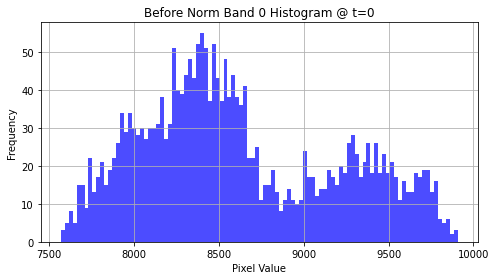

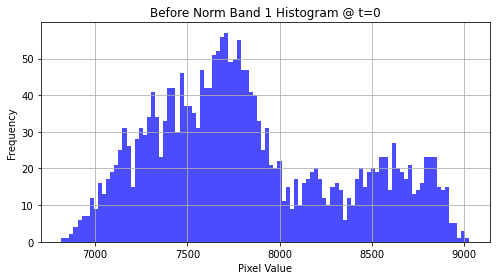

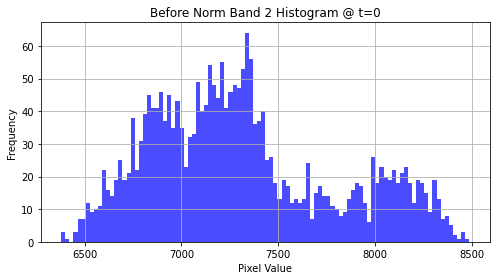

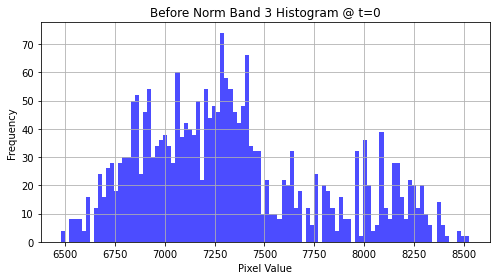

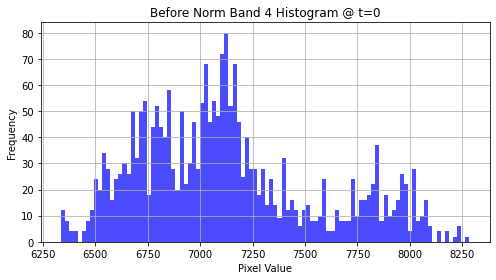

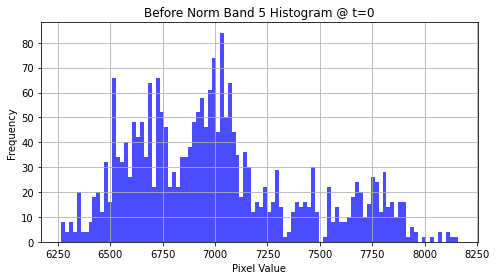

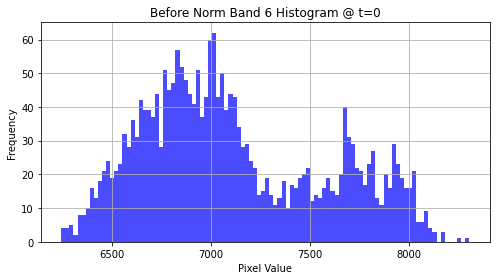

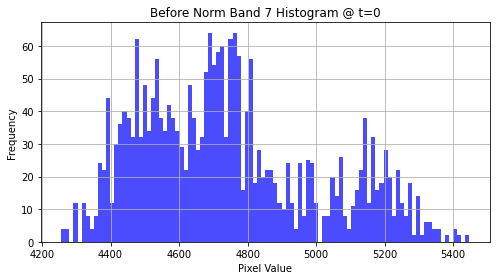

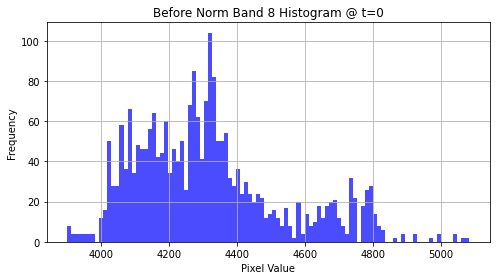

In [7]:


def print_band_summary(X, timestep=0, sample_id=0):
    print(f"\n📦 Sample {sample_id}, Timestep {timestep}, Shape: {X.shape}")
    print("Band | Mean     Std     Min     Max     P25     P50     P75     Skew   Kurt")

    for b in range(X.shape[1]):
        band_data = X[timestep, b].astype(np.float64).flatten()
        mean = band_data.mean()
        std = band_data.std()
        vmin = band_data.min()
        vmax = band_data.max()
        p25 = np.percentile(band_data, 25)
        p50 = np.percentile(band_data, 50)
        p75 = np.percentile(band_data, 75)
        sk = skew(band_data)
        kurt = kurtosis(band_data)
        
        print(f"{b:>4} | {mean:7.2f} {std:7.2f} {vmin:7.2f} {vmax:7.2f} {p25:7.2f} {p50:7.2f} {p75:7.2f} {sk:7.2f} {kurt:7.2f}")

# Example usage:
X, y = all_data[0]
print_band_summary(X, timestep=0, sample_id=0)

for b in range(9):  # for all 9 bands
    X, _ = all_data[13]
    plot_band_histogram(X, band=b, timestep=0, title_prefix="Before Norm")

In [8]:
#Z-score normalisaiton
for i in range(len(all_data)):
    X, y = all_data[i]
    X = X.astype(np.float32)  
    for b in range(BANDS):
        X[:, b] = (X[:, b] - means[b]) / stds[b]
    all_data[i] = (X, y)



📦 Sample 0, Timestep 0, Shape: (34, 9, 48, 48)
Band | Mean     Std     Min     Max     P25     P50     P75     Skew   Kurt
   0 |    2.32    0.09    1.99    2.60    2.26    2.32    2.37   -0.02    0.24
   1 |    2.08    0.08    1.76    2.36    2.03    2.08    2.13   -0.05    0.38
   2 |    1.89    0.08    1.63    2.24    1.84    1.89    1.95    0.15    0.82
   3 |    1.86    0.08    1.62    2.21    1.81    1.86    1.91    0.34    1.15
   4 |    1.73    0.09    1.50    2.11    1.67    1.73    1.79    0.33    0.83
   5 |    1.68    0.10    1.40    2.11    1.61    1.68    1.75    0.36    0.65
   6 |    1.69    0.10    1.35    2.04    1.63    1.70    1.75    0.07    0.39
   7 |    1.31    0.10    1.05    1.72    1.24    1.31    1.38    0.28    0.47
   8 |    1.74    0.12    1.42    2.17    1.66    1.75    1.83    0.01   -0.06


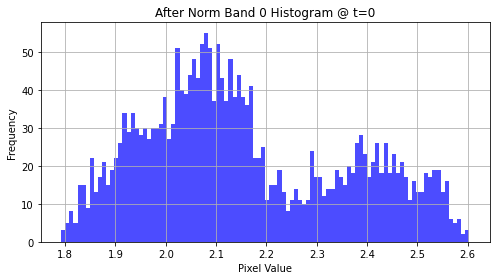

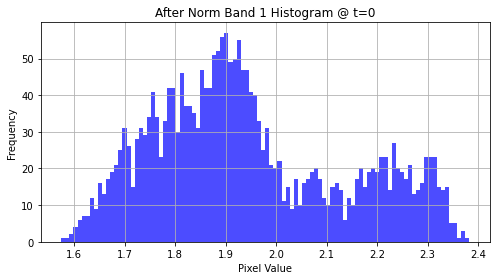

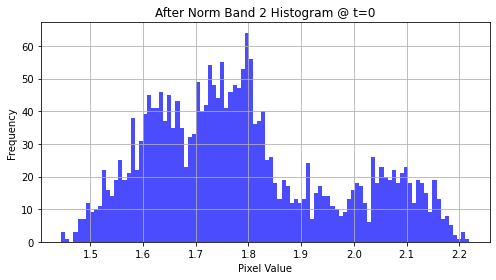

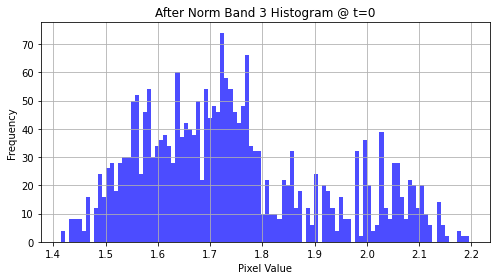

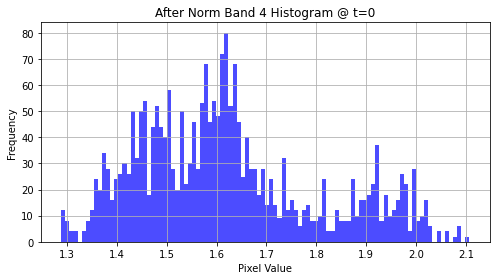

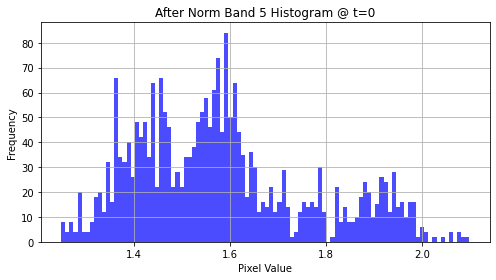

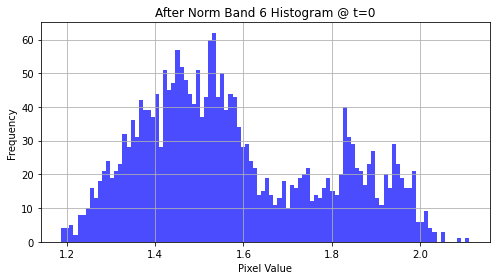

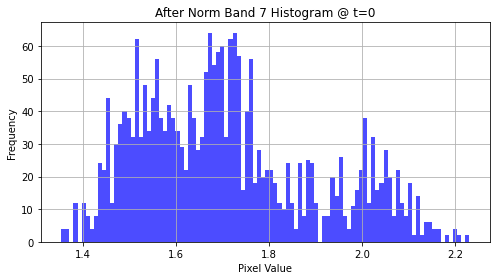

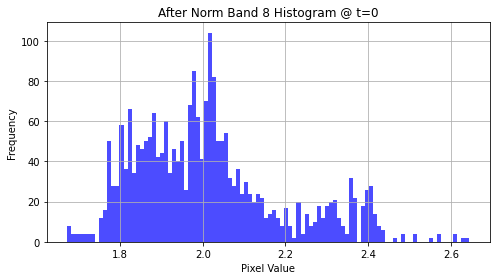

In [9]:

def print_band_summary(X, timestep=0, sample_id=0):
    print(f"\n📦 Sample {sample_id}, Timestep {timestep}, Shape: {X.shape}")
    print("Band | Mean     Std     Min     Max     P25     P50     P75     Skew   Kurt")

    for b in range(X.shape[1]):
        band_data = X[timestep, b].astype(np.float64).flatten()
        mean = band_data.mean()
        std = band_data.std()
        vmin = band_data.min()
        vmax = band_data.max()
        p25 = np.percentile(band_data, 25)
        p50 = np.percentile(band_data, 50)
        p75 = np.percentile(band_data, 75)
        sk = skew(band_data)
        kurt = kurtosis(band_data)
        
        print(f"{b:>4} | {mean:7.2f} {std:7.2f} {vmin:7.2f} {vmax:7.2f} {p25:7.2f} {p50:7.2f} {p75:7.2f} {sk:7.2f} {kurt:7.2f}")

# Example usage:
X, y = all_data[0]
print_band_summary(X, timestep=0, sample_id=0)

for b in range(9):  # for all 9 bands
    X, _ = all_data[13]
    plot_band_histogram(X, band=b, timestep=0, title_prefix="After Norm")

In [10]:
label_counter = Counter()

for _, y in all_data:
    flat_labels = y.flatten()
    label_counter.update(flat_labels.tolist())

# Sort the label counts
label_counts = dict(sorted(label_counter.items()))

# ✅ Total number of unique labels
num_labels = len(label_counts)

# ✅ Total number of labeled pixels
total_pixels = sum(label_counts.values())



# 🔍 Print everything
print(f"🔢 Total unique labels: {num_labels}")
print(f"🧮 Total labeled pixels: {total_pixels}")
print("📊 Label Frequencies:")
for label, count in label_counts.items():
    print(f"  Label {label}: {count} pixels")

🔢 Total unique labels: 7
🧮 Total labeled pixels: 3456000
📊 Label Frequencies:
  Label 0: 291407 pixels
  Label 1: 730362 pixels
  Label 2: 781280 pixels
  Label 3: 311628 pixels
  Label 4: 516137 pixels
  Label 5: 275921 pixels
  Label 6: 549265 pixels


In [11]:

label_counter = Counter()

for _, mask in all_data:
    unique, counts = np.unique(mask, return_counts=True)
    label_counter.update(dict(zip(unique, counts)))

print("Class pixel counts:", dict(label_counter))

num_classes = 7
total_pixels = sum(label_counter.values())

weights = []
for cls in range(num_classes):
    cls_count = label_counter.get(cls, 0)
    if cls_count == 0:
        weights.append(0.0)  # Unused class
    else:
        freq = cls_count / total_pixels
        weights.append(1.0 / freq)

# Step 5: Convert to torch.Tensor
class_weights = torch.tensor(weights, dtype=torch.float32).to(device)

print("Class weights:", class_weights)


Class pixel counts: {0: 291407, 1: 730362, 3: 311628, 5: 275921, 6: 549265, 4: 516137, 2: 781280}
Class weights: tensor([11.8597,  4.7319,  4.4235, 11.0901,  6.6959, 12.5253,  6.2920],
       device='cuda:0')


In [12]:
#fixed seed
np.random.seed(13)

#80/20 split
total_len = len(all_data)
train_len = int(0.8 * total_len)
val_len = total_len - train_len
train_raw, val_raw = random_split(all_data, [train_len, val_len])

print(f"Total samples: {len(all_data)}")
print(f"Train samples: {len(train_raw)}")
print(f"Test samples:  {len(val_raw)}")

Total samples: 1500
Train samples: 1200
Test samples:  300


In [13]:

def analyze_timesteps(data):
    timestep_counts = defaultdict(int)

    for X, _ in data:
        T = X.shape[0]
        timestep_counts[T] += 1

    # Print detailed info
    print("📊 Unique Time Step Counts:")
    for T in sorted(timestep_counts):
        print(f"  T = {T}: {timestep_counts[T]} tiles")

    print(f"\n🧮 Total Unique T values: {len(timestep_counts)}")
    return timestep_counts

# Example usage
analyze_timesteps(train_raw)



📊 Unique Time Step Counts:
  T = 33: 206 tiles
  T = 34: 210 tiles
  T = 53: 386 tiles
  T = 68: 207 tiles
  T = 71: 191 tiles

🧮 Total Unique T values: 5


defaultdict(int, {53: 386, 71: 191, 34: 210, 68: 207, 33: 206})

Image sequence shape: (34, 9, 48, 48)
Ground truth shape: (48, 48)


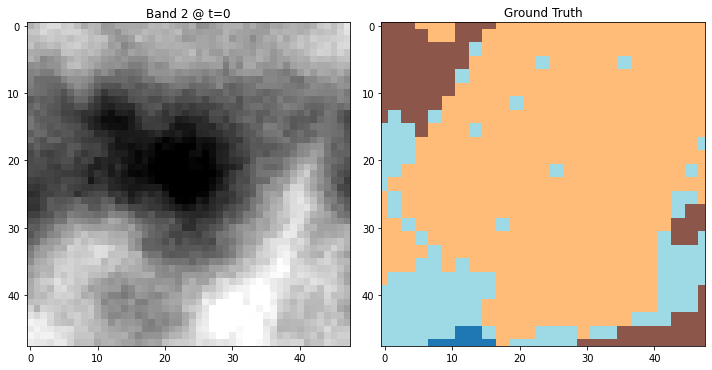

In [14]:
def plot_sample(X, y, timestep=0, band=3):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    img = X[timestep, band]
    
    # Normalize visualization range to make contrast visible
    vmin = np.percentile(img, 2)
    vmax = np.percentile(img, 98)

    axs[0].imshow(img, cmap='gray', vmin=vmin, vmax=vmax)
    axs[0].set_title(f'Band {band} @ t={timestep}')

    axs[1].imshow(y, cmap='tab20')
    axs[1].set_title('Ground Truth')

    plt.tight_layout()
    plt.show()


# Plot a sample
sample_X, sample_y = all_data[20]
print(f"Image sequence shape: {sample_X.shape}")  # (T, 9, 48, 48)
print(f"Ground truth shape: {sample_y.shape}")    # (48, 48)
plot_sample(sample_X, sample_y, timestep=0, band=2)


# Model

In [15]:
class CNN(nn.Module):
    def __init__(self, in_channels=32*9, num_classes=7, dropout=0.3):
        super().__init__()

        def res_block(in_ch, out_ch, dilation):
            skip = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=dilation, dilation=dilation),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(),
                nn.Dropout2d(dropout),
                
                nn.Conv2d(out_ch, out_ch, 3, padding=dilation, dilation=dilation),
                nn.BatchNorm2d(out_ch),
                nn.Dropout2d(dropout),
                nn.ReLU(),
                
                nn.Sequential(skip)  # identity if same shape, otherwise 1x1 conv
            )

        self.encoder1 = res_block(in_channels, 256, dilation=1)
        self.encoder2 = res_block(256, 256, dilation=2)
        self.encoder3 = res_block(256, 256, dilation=4)
        self.encoder4 = res_block(256, 512, dilation=2)
        self.encoder5 = res_block(512, 512, dilation=1)
        self.final_conv = nn.Conv2d(512, num_classes, kernel_size=1)

    def forward(self, x):
        # Manual forward pass for residual + skip connections
        def forward_res_block(x, block):
            skip = block[-1][0](x)
            out = block[0](x)
            out = block[1](out)
            out = block[2](out)
            out = block[3](out)
            out = block[4](out)
            out = block[5](out)
            out = block[6](out)
            return F.relu(out + skip)

        x = forward_res_block(x, self.encoder1)
        x = forward_res_block(x, self.encoder2)
        x = forward_res_block(x, self.encoder3)
        x = forward_res_block(x, self.encoder4)
        x = forward_res_block(x, self.encoder5)
        return self.final_conv(x)


In [16]:

class CustomDataset(Dataset):
    def __init__(self, tiles, label_smoothing=0.1, num_classes=7, augment=False, noise_std=0.01):
        self.tiles = tiles
        self.augment = augment
        self.label_smoothing = label_smoothing
        self.num_classes = num_classes
        self.noise_std = noise_std

        self.aug = T.Compose([
            T.RandomHorizontalFlip(),
            T.RandomVerticalFlip(),
            T.RandomRotation(15, interpolation=InterpolationMode.BILINEAR),
        ])

    def __len__(self):
        return len(self.tiles)

    def __getitem__(self, idx):
        X, y = self.tiles[idx]  # X: (32, 9, 48, 48), y: (48, 48)
        X = torch.from_numpy(X.reshape(-1, 48, 48)).clone()  # shape: (T*9, 48, 48)
        y = torch.from_numpy(y).long().clone()    # (32*9, 48, 48)

        if self.augment:
            seed = random.randint(0, 99999)
            torch.manual_seed(seed)
            X = self.aug(X)
            torch.manual_seed(seed)
            y = self.aug(y.unsqueeze(0)).squeeze(0).long()

        #gaussian noise
        X = X + torch.randn_like(X) * self.noise_std

        return X.float(), y.long()  

def get_dataloaders(train_tiles, val_tiles, batch_size=16, timesteps=32):
    train_tiles = [(X[:timesteps], y) for X, y in train_tiles]
    val_tiles = [(X[:timesteps], y) for X, y in val_tiles]

    train_ds = CustomDataset(train_tiles, augment=True)
    val_ds = CustomDataset(val_tiles, augment=False)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    return train_loader, val_loader



# Training

In [17]:
t=32
num_epochs = 30
lr = 1e-3
weight_decay = 1e-4
label_smoothing = 0.1

train_loader, val_loader = get_dataloaders(train_raw, val_raw, batch_size=16, timesteps=t)

model = CNN(in_channels=t*9, num_classes=7).to(device) 
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
criterion = nn.CrossEntropyLoss(weight = class_weights,label_smoothing=label_smoothing)

train_losses, val_losses = [], []
train_accs, val_accs = [], []

# --- Training Loop ---
for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0.0, 0, 0

    for X, y in tqdm(train_loader, desc=f"[Train] Epoch {epoch+1}/{num_epochs}"):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(X)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pred = logits.argmax(1)
        correct += (pred == y).sum().item()
        total += y.numel()

    train_losses.append(total_loss / len(train_loader))
    train_accs.append(100 * correct / total)

    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for X, y in tqdm(val_loader, desc=f"[Val] Epoch {epoch+1}/{num_epochs}", leave=False):
            X, y = X.to(device), y.to(device)
            logits = model(X)
            loss = criterion(logits, y)
            val_loss += loss.item()
            pred = logits.argmax(1)
            val_correct += (pred == y).sum().item()
            val_total += y.numel()

    val_losses.append(val_loss / len(val_loader))
    val_accs.append(100 * val_correct / val_total)
    scheduler.step()

    print(f"Epoch {epoch+1:02d} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f} | "
          f"Train Acc: {train_accs[-1]:.2f}% | Val Acc: {val_accs[-1]:.2f}%")




[Train] Epoch 1/30: 100%|██████████| 75/75 [00:27<00:00,  2.72it/s]


Epoch 01 | Train Loss: 1.9735 | Val Loss: 1.7763 | Train Acc: 25.60% | Val Acc: 23.02%


[Train] Epoch 2/30: 100%|██████████| 75/75 [00:21<00:00,  3.46it/s]


Epoch 02 | Train Loss: 1.6927 | Val Loss: 1.7166 | Train Acc: 35.94% | Val Acc: 40.89%


[Train] Epoch 3/30: 100%|██████████| 75/75 [00:21<00:00,  3.45it/s]


Epoch 03 | Train Loss: 1.5887 | Val Loss: 1.5337 | Train Acc: 45.02% | Val Acc: 51.22%


[Train] Epoch 4/30: 100%|██████████| 75/75 [00:21<00:00,  3.46it/s]


Epoch 04 | Train Loss: 1.5089 | Val Loss: 1.4938 | Train Acc: 50.64% | Val Acc: 52.76%


[Train] Epoch 5/30: 100%|██████████| 75/75 [00:21<00:00,  3.47it/s]


Epoch 05 | Train Loss: 1.4620 | Val Loss: 1.4105 | Train Acc: 52.77% | Val Acc: 57.56%


[Train] Epoch 6/30: 100%|██████████| 75/75 [00:21<00:00,  3.46it/s]


Epoch 06 | Train Loss: 1.3722 | Val Loss: 1.3321 | Train Acc: 57.77% | Val Acc: 61.64%


[Train] Epoch 7/30: 100%|██████████| 75/75 [00:21<00:00,  3.43it/s]


Epoch 07 | Train Loss: 1.3550 | Val Loss: 1.3399 | Train Acc: 58.60% | Val Acc: 62.64%


[Train] Epoch 8/30: 100%|██████████| 75/75 [00:21<00:00,  3.44it/s]


Epoch 08 | Train Loss: 1.3402 | Val Loss: 1.3514 | Train Acc: 59.73% | Val Acc: 61.84%


[Train] Epoch 9/30: 100%|██████████| 75/75 [00:21<00:00,  3.45it/s]


Epoch 09 | Train Loss: 1.3327 | Val Loss: 1.3064 | Train Acc: 59.78% | Val Acc: 64.28%


[Train] Epoch 10/30: 100%|██████████| 75/75 [00:21<00:00,  3.46it/s]


Epoch 10 | Train Loss: 1.3175 | Val Loss: 1.2874 | Train Acc: 60.88% | Val Acc: 65.05%


[Train] Epoch 11/30: 100%|██████████| 75/75 [00:21<00:00,  3.44it/s]


Epoch 11 | Train Loss: 1.2816 | Val Loss: 1.2786 | Train Acc: 62.44% | Val Acc: 65.60%


[Train] Epoch 12/30: 100%|██████████| 75/75 [00:21<00:00,  3.43it/s]


Epoch 12 | Train Loss: 1.2687 | Val Loss: 1.2739 | Train Acc: 63.28% | Val Acc: 65.87%


[Train] Epoch 13/30: 100%|██████████| 75/75 [00:21<00:00,  3.45it/s]


Epoch 13 | Train Loss: 1.2635 | Val Loss: 1.2595 | Train Acc: 63.20% | Val Acc: 67.42%


[Train] Epoch 14/30: 100%|██████████| 75/75 [00:21<00:00,  3.45it/s]


Epoch 14 | Train Loss: 1.2629 | Val Loss: 1.2645 | Train Acc: 63.77% | Val Acc: 66.64%


[Train] Epoch 15/30: 100%|██████████| 75/75 [00:21<00:00,  3.43it/s]


Epoch 15 | Train Loss: 1.2534 | Val Loss: 1.2433 | Train Acc: 64.18% | Val Acc: 67.95%


[Train] Epoch 16/30: 100%|██████████| 75/75 [00:21<00:00,  3.46it/s]


Epoch 16 | Train Loss: 1.2369 | Val Loss: 1.2481 | Train Acc: 65.01% | Val Acc: 67.59%


[Train] Epoch 17/30: 100%|██████████| 75/75 [00:21<00:00,  3.46it/s]


Epoch 17 | Train Loss: 1.2302 | Val Loss: 1.2361 | Train Acc: 65.08% | Val Acc: 68.25%


[Train] Epoch 18/30: 100%|██████████| 75/75 [00:21<00:00,  3.45it/s]


Epoch 18 | Train Loss: 1.2306 | Val Loss: 1.2313 | Train Acc: 65.43% | Val Acc: 68.46%


[Train] Epoch 19/30: 100%|██████████| 75/75 [00:21<00:00,  3.43it/s]


Epoch 19 | Train Loss: 1.2252 | Val Loss: 1.2275 | Train Acc: 65.35% | Val Acc: 68.63%


[Train] Epoch 20/30: 100%|██████████| 75/75 [00:21<00:00,  3.45it/s]


Epoch 20 | Train Loss: 1.2168 | Val Loss: 1.2333 | Train Acc: 66.07% | Val Acc: 68.38%


[Train] Epoch 21/30: 100%|██████████| 75/75 [00:21<00:00,  3.45it/s]


Epoch 21 | Train Loss: 1.2157 | Val Loss: 1.2252 | Train Acc: 65.92% | Val Acc: 68.91%


[Train] Epoch 22/30: 100%|██████████| 75/75 [00:21<00:00,  3.46it/s]


Epoch 22 | Train Loss: 1.2088 | Val Loss: 1.2241 | Train Acc: 66.32% | Val Acc: 68.74%


[Train] Epoch 23/30: 100%|██████████| 75/75 [00:21<00:00,  3.45it/s]


Epoch 23 | Train Loss: 1.2007 | Val Loss: 1.2277 | Train Acc: 66.52% | Val Acc: 68.32%


[Train] Epoch 24/30: 100%|██████████| 75/75 [00:21<00:00,  3.46it/s]


Epoch 24 | Train Loss: 1.2000 | Val Loss: 1.2213 | Train Acc: 66.72% | Val Acc: 69.04%


[Train] Epoch 25/30: 100%|██████████| 75/75 [00:21<00:00,  3.46it/s]


Epoch 25 | Train Loss: 1.2037 | Val Loss: 1.2156 | Train Acc: 66.81% | Val Acc: 69.43%


[Train] Epoch 26/30: 100%|██████████| 75/75 [00:21<00:00,  3.46it/s]


Epoch 26 | Train Loss: 1.1963 | Val Loss: 1.2131 | Train Acc: 66.96% | Val Acc: 69.47%


[Train] Epoch 27/30: 100%|██████████| 75/75 [00:21<00:00,  3.46it/s]


Epoch 27 | Train Loss: 1.1959 | Val Loss: 1.2158 | Train Acc: 67.10% | Val Acc: 69.66%


[Train] Epoch 28/30: 100%|██████████| 75/75 [00:21<00:00,  3.42it/s]


Epoch 28 | Train Loss: 1.1928 | Val Loss: 1.2207 | Train Acc: 67.39% | Val Acc: 69.18%


[Train] Epoch 29/30: 100%|██████████| 75/75 [00:21<00:00,  3.45it/s]


Epoch 29 | Train Loss: 1.1913 | Val Loss: 1.2202 | Train Acc: 67.31% | Val Acc: 69.26%


[Train] Epoch 30/30: 100%|██████████| 75/75 [00:21<00:00,  3.45it/s]
                                                                  

Epoch 30 | Train Loss: 1.1910 | Val Loss: 1.2175 | Train Acc: 67.42% | Val Acc: 69.45%


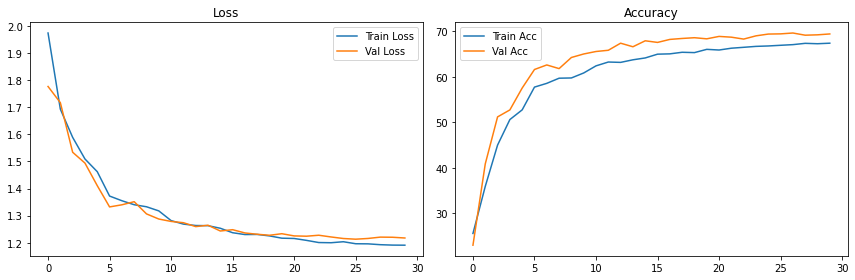

In [18]:
# --- Plotting ---
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.title("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

# Evalutaion

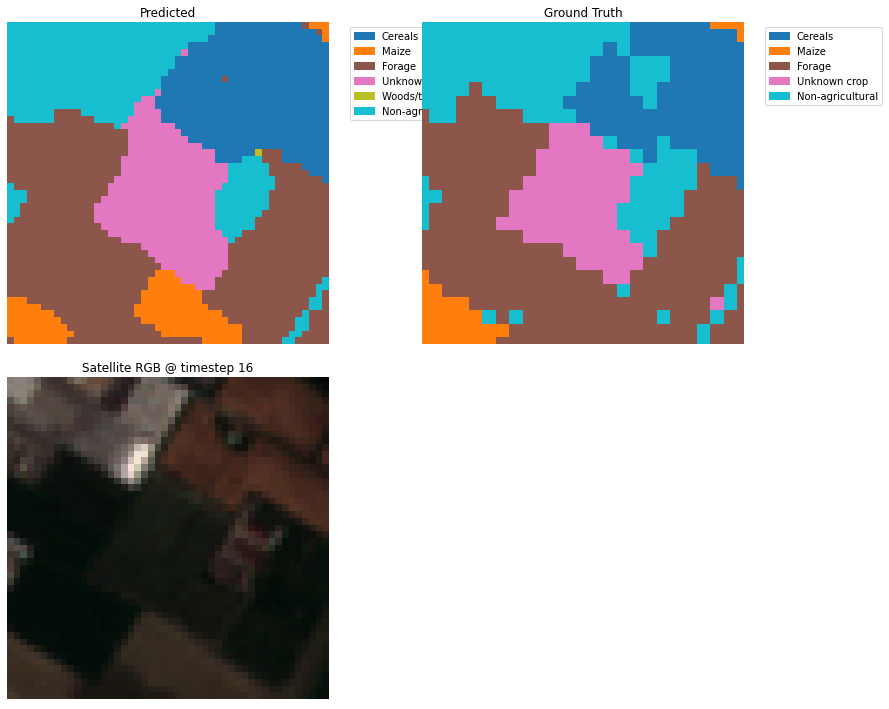

In [49]:
def visualize(model, dataset, idx=0, num_classes=7, label_names=None, rgb_bands=(2, 1, 0), timestep=16):
    model.eval()

    # === Load data ===
    X, y = dataset[idx]           # X: (C*T, H, W), y: (H, W)
    X_input = X.unsqueeze(0).to(device)

    with torch.no_grad():
        pred = model(X_input).argmax(1).squeeze().cpu().numpy()

    y = y.numpy()

    # === Reshape for RGB ===
    C = 9
    T = X.shape[0] // C
    H, W = X.shape[1], X.shape[2]

    X_vis = X.view(T, C, H, W)  # (T, C, H, W)
    rgb = X_vis[timestep][list(rgb_bands)].numpy()
    rgb = np.transpose(rgb, (1, 2, 0))
    rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min() + 1e-6)  # normalize

    # === Color Map and Legend ===
    cmap = plt.cm.get_cmap('tab10', num_classes)
    pred_classes = np.unique(pred)
    gt_classes = np.unique(y)

    pred_legend = [mpatches.Patch(color=cmap(cls), label=label_names[cls]) for cls in pred_classes] if label_names else []
    gt_legend = [mpatches.Patch(color=cmap(cls), label=label_names[cls]) for cls in gt_classes] if label_names else []

    # === Plotting ===
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    # Top row: Pred and GT
    axs[0, 0].imshow(pred, cmap=cmap, vmin=0, vmax=num_classes-1)
    axs[0, 0].set_title("Predicted")
    axs[0, 0].axis("off")
    if pred_legend:
        axs[0, 0].legend(handles=pred_legend, bbox_to_anchor=(1.05, 1), loc='upper left')

    axs[0, 1].imshow(y, cmap=cmap, vmin=0, vmax=num_classes-1)
    axs[0, 1].set_title("Ground Truth")
    axs[0, 1].axis("off")
    if gt_legend:
        axs[0, 1].legend(handles=gt_legend, bbox_to_anchor=(1.05, 1), loc='upper left')

    # Bottom left: Satellite RGB
    axs[1, 0].imshow(rgb)
    axs[1, 0].set_title(f"Satellite RGB @ timestep {timestep}")
    axs[1, 0].axis("off")

    # Bottom right: hide unused
    axs[1, 1].axis("off")

    plt.tight_layout()
    plt.show()

label_names = {
    0: "Cereals",
    1: "Maize",
    2: "Rice",
    3: "Forage",
    4: "Unknown crop",
    5: "Woods/tree crops",
    6: "Non-agricultural"
}

val_tile = [(X[:32], y) for X, y in val_raw]
val_ds = CustomDataset(val_tile, augment=False)
visualize(model, val_ds, idx=15, num_classes=7, label_names=label_names,timestep = 16)





           Class  Total Pixels  Pred Pixels  Accuracy    IoU
         Cereals         64275        72384    0.7579 0.5539
           Maize        143445       132067    0.7347 0.6195
            Rice        178002       195582    0.9152 0.7732
          Forage         58554        67653    0.6996 0.4806
    Unknown crop         86047        61660    0.3673 0.2722
Woods/tree crops         51711        93106    0.8599 0.4431
Non-agricultural        109166        68748    0.4216 0.3490

Total Accuracy: 0.6945
Mean IoU: 0.4988
F1 Score (macro): 0.6512


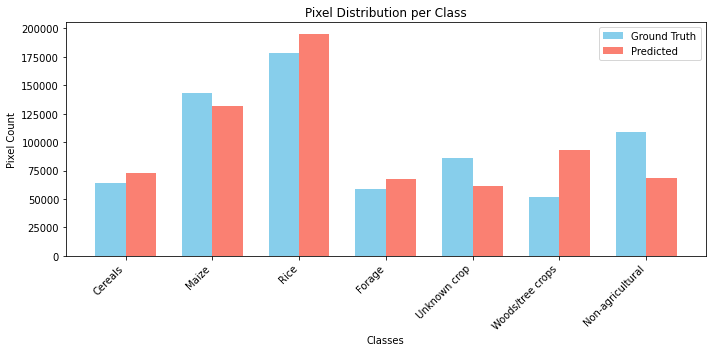

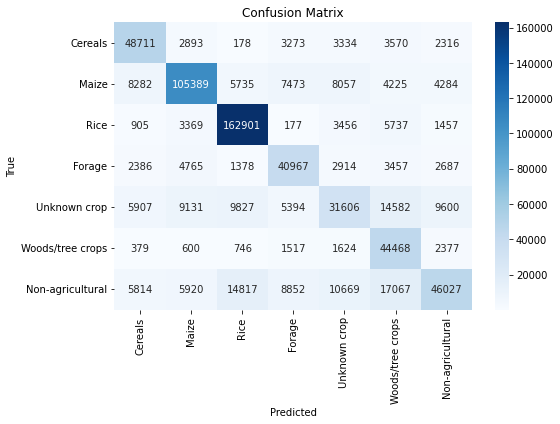

In [52]:
def evaluate_combined(model, loader, label_names, num_classes=7):
    model.eval()
    pred_counts = np.zeros(num_classes, dtype=int)
    gt_counts = np.zeros(num_classes, dtype=int)
    correct = 0
    total = 0

    all_preds = []
    all_gts = []

    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            preds = model(X).argmax(1)

            preds_np = preds.cpu().numpy().flatten()
            y_np = y.cpu().numpy().flatten()

            for cls in range(num_classes):
                pred_counts[cls] += np.sum(preds_np == cls)
                gt_counts[cls] += np.sum(y_np == cls)

            correct += np.sum(preds_np == y_np)
            total += y_np.size

            all_preds.extend(preds_np)
            all_gts.extend(y_np)

    all_preds = np.array(all_preds)
    all_gts = np.array(all_gts)

    acc = correct / total

    cm = confusion_matrix(all_gts, all_preds, labels=list(range(num_classes)))
    intersection = np.diag(cm)
    union = np.sum(cm, axis=0) + np.sum(cm, axis=1) - intersection
    iou = np.round(intersection / (union + 1e-10),4)
    class_acc = np.round(intersection / (np.sum(cm, axis=1) + 1e-10),4)

    df = pd.DataFrame({
        'Class': [label_names[c] for c in range(num_classes)],
        'Total Pixels': gt_counts,
        'Pred Pixels': pred_counts,
        'Accuracy': class_acc,
        'IoU': iou
    })

    print(df.to_string(index=False))
    print(f"\nTotal Accuracy: {acc:.4f}")
    print(f"Mean IoU: {np.mean(iou):.4f}")
    print(f"F1 Score (macro): {f1_score(all_gts, all_preds, average='macro'):.4f}")

    plt.figure(figsize=(10, 5))
    bar_width = 0.35
    x = np.arange(num_classes)
    plt.bar(x - bar_width/2, gt_counts, bar_width, label='Ground Truth', color='skyblue')
    plt.bar(x + bar_width/2, pred_counts, bar_width, label='Predicted', color='salmon')
    plt.xlabel("Classes")
    plt.ylabel("Pixel Count")
    plt.title("Pixel Distribution per Class")
    plt.xticks(x, [label_names[cls] for cls in range(num_classes)], rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=[label_names[i] for i in range(num_classes)],
                yticklabels=[label_names[i] for i in range(num_classes)], cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()


evaluate_combined(model, val_loader, label_names, num_classes=7)

# Loading Model

In [20]:
epoch = 10
model.load_state_dict(torch.load(f"model_epoch_{epoch}.pth"))
model.to(device)


FileNotFoundError: [Errno 2] No such file or directory: 'model_epoch_10.pth'